## setup

In [8]:
! pip install tensorflow numpy matplotlib torch torchvision

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

## Tensorflow

### Transformation Feature Extractor

In [ ]:
# =============================
# Differentiable Transformation Network (DTN) Full Notebook
# With: Real Data Loading + Visualization
# =============================


import tensorflow as tf
from tensorflow.keras import layers, models


print("TensorFlow version:", tf.__version__)

# =============================

# 🧱 Step 2: Build Transformation Feature Extractor

def build_dtn(input_shape=(500, 500, 3), tf_channels=12, backbone="resnet", k=4):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for i in range(k):
        if backbone == "resnet":
            shortcut = x
            # 🛠 Match channel dimensions using 1x1 conv
            if x.shape[-1] != 64:
                shortcut = layers.Conv2D(64, 1, padding='same')(shortcut)

            x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
            x = layers.Conv2D(64, 3, padding='same')(x)
            x = layers.Add()([shortcut, x])
            x = layers.ReLU()(x)
        elif backbone == "densenet":
            dense_input = x
            x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
            x = layers.Concatenate()([dense_input, x])
        else:  # plain CNN
            x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

        x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(tf_channels, 1, padding='same')(x)
    model = models.Model(inputs, x, name=f"DTN_{backbone}_k{k}")
    return model

# =============================

# 🔄 Step 3: Build Expected Texture Transformer

def expected_texture_transformer(tf_features, eta_exp):
    subtractor = tf_features[..., 0:3]
    adder1 = tf_features[..., 3:6]
    multiplier = tf_features[..., 6:9]
    adder2 = tf_features[..., 9:12]

    x = (eta_exp - subtractor)
    x = x + adder1
    x = x * multiplier
    x = x + adder2
    return x

# =============================

# 🏋️ Step 4: Define Training Loop

def train_dtn(x_ref, eta_exp, x_ren, epochs=25, batch_size=16, backbone="resnet", k=4):
    dtn_model = build_dtn(backbone=backbone, k=k)
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    dataset = tf.data.Dataset.from_tensor_slices((x_ref, eta_exp, x_ren))
    dataset = dataset.shuffle(1000).batch(batch_size)

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_xref, batch_etaexp, batch_xren in dataset:
            with tf.GradientTape() as tape:
                tf_features = dtn_model(batch_xref, training=True)

                tf_features = tf.image.resize(tf_features, size=(batch_etaexp.shape[1], batch_etaexp.shape[2]), method='bilinear')

                x_recon = expected_texture_transformer(tf_features, batch_etaexp)
                loss = loss_fn(batch_xren, x_recon)

            grads = tape.gradient(loss, dtn_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, dtn_model.trainable_weights))
            epoch_loss += loss.numpy()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

    return dtn_model

# =============================

# 📥 Step 5: Real Data Loading (From Files)

def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)

# Example folder structure
# /content/
#   ref_images/  --> x_ref (masked rendered object images)
#   exp_textures/ --> eta_exp (expected textures, flat color masked images)
#   ren_images/ --> x_ren (ground truth rendered images)

real_data = False

# You can upload and load your real datasets if available
if os.path.exists('dataset/reference'):
    print("Loading real datasets...")
    x_ref = load_images_from_folder('dataset/reference')
    eta_exp = load_images_from_folder('dataset/texture')
    x_ren = load_images_from_folder('dataset/rendered')
    real_data = True
else:
    print("Real data folders not found. Using dummy random data...")
    num_samples = 100
    x_ref = np.random.rand(num_samples, 500, 500, 3).astype(np.float32)
    eta_exp = np.random.rand(num_samples, 500, 500, 3).astype(np.float32)
    x_ren = np.random.rand(num_samples, 500, 500, 3).astype(np.float32)

print("Data loaded:", x_ref.shape, eta_exp.shape, x_ren.shape)

# =============================

# 🚀 Step 6: Train DTN Model

print("\nStarting DTN Training...")
trained_model = train_dtn(x_ref, eta_exp, x_ren, epochs=25, batch_size=32, backbone="resnet", k=4)

# =============================

# 💾 Step 7: Save Model
trained_model.save("dtn_model_real.h5")
print("\nModel saved as dtn_model_real.h5 ✅")



2025-05-06 15:34:49.418125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-06 15:34:49.504839: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 15:34:49.507882: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2025-05-06 15:34:49.507892:

TensorFlow version: 2.11.0
Loading real datasets...
Data loaded: (100, 500, 500, 3) (100, 500, 500, 3) (100, 500, 500, 3)

Starting DTN Training...


2025-05-06 15:34:51.745704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-06 15:34:51.745878: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2025-05-06 15:34:51.745928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2025-05-06 15:34:51.745965: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dler

Epoch 1/25 - Loss: 0.8104
Epoch 2/25 - Loss: 0.7240
Epoch 3/25 - Loss: 0.7165
Epoch 4/25 - Loss: 0.5575
Epoch 5/25 - Loss: 0.4972
Epoch 6/25 - Loss: 0.5908
Epoch 7/25 - Loss: 0.4543
Epoch 8/25 - Loss: 0.4792
Epoch 9/25 - Loss: 0.4526
Epoch 10/25 - Loss: 0.4929
Epoch 11/25 - Loss: 0.4734
Epoch 12/25 - Loss: 0.4803
Epoch 13/25 - Loss: 0.4591
Epoch 14/25 - Loss: 0.5567
Epoch 15/25 - Loss: 0.4936
Epoch 16/25 - Loss: 0.4820
Epoch 17/25 - Loss: 0.4808
Epoch 18/25 - Loss: 0.5498
Epoch 19/25 - Loss: 0.5037
Epoch 20/25 - Loss: 0.4415
Epoch 21/25 - Loss: 0.4945
Epoch 22/25 - Loss: 0.5169
Epoch 23/25 - Loss: 0.4569
Epoch 24/25 - Loss: 0.5601
Epoch 25/25 - Loss: 0.5508

Model saved as dtn_model_real.h5 ✅


1/1 [==============================] - 0s 104ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


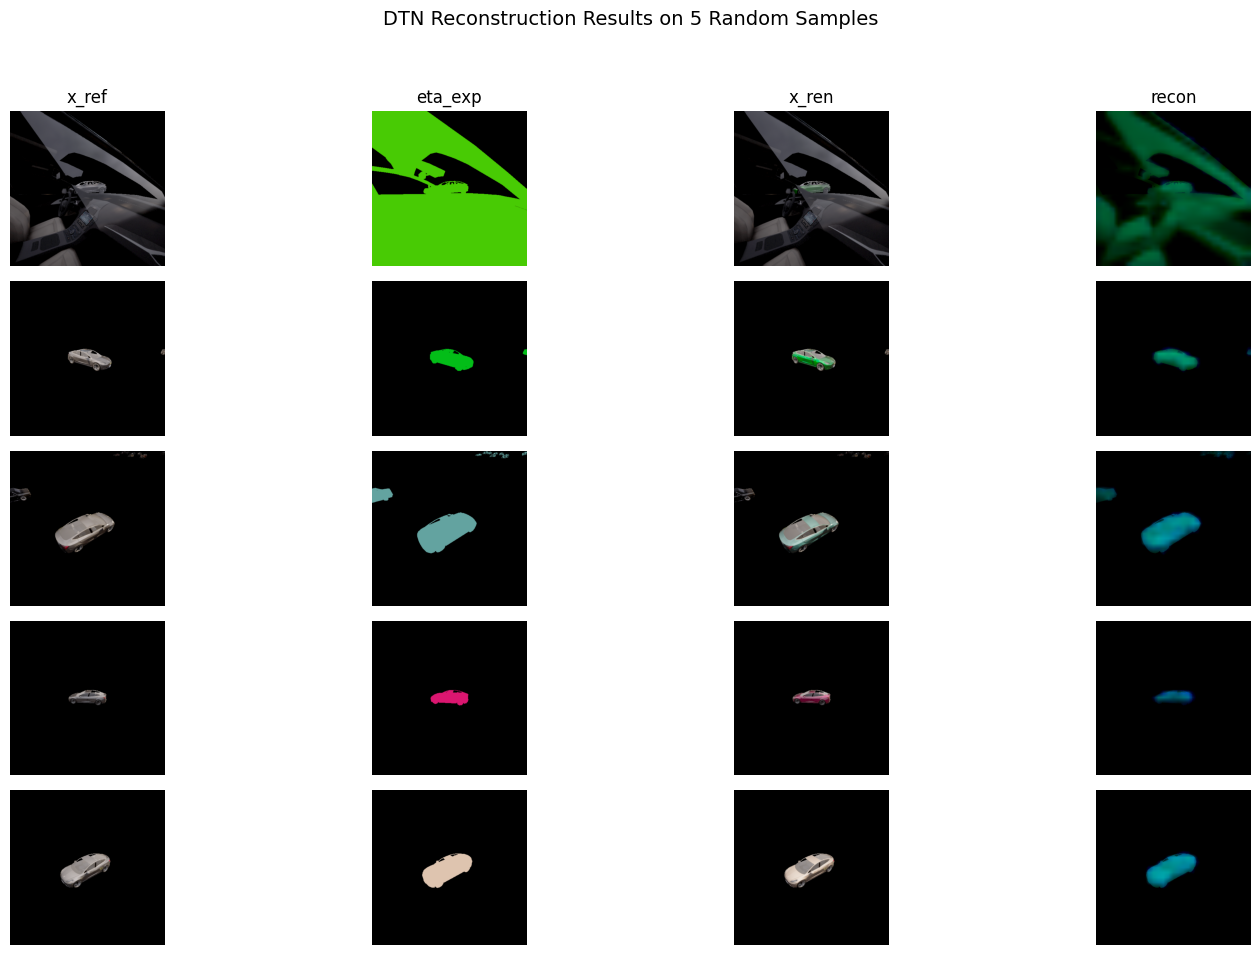

In [ ]:
# =============================

# Step 8: Visualize TF and Reconstruction Output

# Visualize 5 Random Predictions
num_visuals = 5
indices = np.random.choice(len(x_ref), size=num_visuals, replace=False)

plt.figure(figsize=(16, num_visuals * 2))

for i, idx in enumerate(indices):
    sample_xref = x_ref[idx:idx+1]
    sample_etaexp = eta_exp[idx:idx+1]
    sample_xren = x_ren[idx:idx+1]

    tf_features = trained_model.predict(sample_xref)
    tf_features = tf.image.resize(tf_features, size=(sample_etaexp.shape[1], sample_etaexp.shape[2]), method='bilinear')
    recon = expected_texture_transformer(tf_features, sample_etaexp).numpy()

    # Split TF into 4 RGB maps
    subtractor = tf_features[..., 0:3]
    adder1     = tf_features[..., 3:6]
    multiplier = tf_features[..., 6:9]
    adder2     = tf_features[..., 9:12]

    feature_maps = [subtractor, adder1, multiplier, adder2]
    titles = ['TF: Subtractor', 'TF: Adder1', 'TF: Multiplier', 'TF: Adder2']

    # # Plot
    # plt.figure(figsize=(12, 4))
    # for j in range(4):
    #     plt.subplot(1, 4, j+1)
    #     # Clip values to [0,1] to visualize
    #     plt.imshow(np.clip(feature_maps[j][0], 0, 1))
    #     plt.title(titles[j])
    #     plt.axis('off')
    # plt.suptitle("Visualizing the 4 Stacked RGB Transformation Features from DTN Output", fontsize=14)
    # plt.tight_layout()
    # plt.show()

    # Plot 4 columns: x_ref, eta_exp, x_ren, recon
    for j, img in enumerate([sample_xref[0], sample_etaexp[0], sample_xren[0], recon[0]]):
        plt.subplot(num_visuals, 4, i * 4 + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(["x_ref", "eta_exp", "x_ren", "recon"][j])

plt.suptitle("DTN Reconstruction Results on 5 Random Samples", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## plain nn

In [60]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob


2025-05-07 16:39:54.887085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 16:39:55.060139: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 16:39:55.678870: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2025-05-07 16:39:55.678959: W t

In [61]:
def build_simple_dtn(input_shape):
    # Inputs
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')

    # Combine inputs along channel dimension
    x = Concatenate()([x_ref_input, eta_exp_input])  # Shape: (H, W, 6)

    # Simple CNN to predict x_ren
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(3, (1, 1), activation='sigmoid', padding='same')(x)  # Output 3 channels

    model = Model(inputs=[x_ref_input, eta_exp_input], outputs=x)
    return model


In [ ]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)


print("Loading real datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')
real_data = True

Loading real datasets...


In [63]:
# Assuming x_ref, eta_exp, and x_ren are loaded with shape (N, H, W, 3)

model = build_simple_dtn(input_shape=(500, 500, 3))

model.compile(optimizer=Adam(1e-3), loss='mse', metrics=[tf.keras.metrics.Accuracy()])

model.fit([x_ref[95:], eta_exp[95:]], x_ren[95:], epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20


2025-05-07 16:40:02.361359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-07 16:40:02.361638: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2025-05-07 16:40:02.462474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2025-05-07 16:40:02.462525: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries menti

1/1 [==============================] - 1s 557ms/step - loss: 0.2457 - accuracy: 0.0000e+00 - val_loss: 0.2460 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 91ms/step - loss: 0.2449 - accuracy: 0.0000e+00 - val_loss: 0.2450 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 86ms/step - loss: 0.2441 - accuracy: 0.0000e+00 - val_loss: 0.2440 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 87ms/step - loss: 0.2432 - accuracy: 0.0000e+00 - val_loss: 0.2430 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 86ms/step - loss: 0.2422 - accuracy: 0.0000e+00 - val_loss: 0.2419 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 84ms/step - loss: 0.2411 - accuracy: 0.0000e+00 - val_loss: 0.2407 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 85ms/step - loss: 0.2400 - accuracy: 0.0000e+00 - val_loss: 0.2395 - val_ac

1/1 [==============================] - 0s 74ms/step


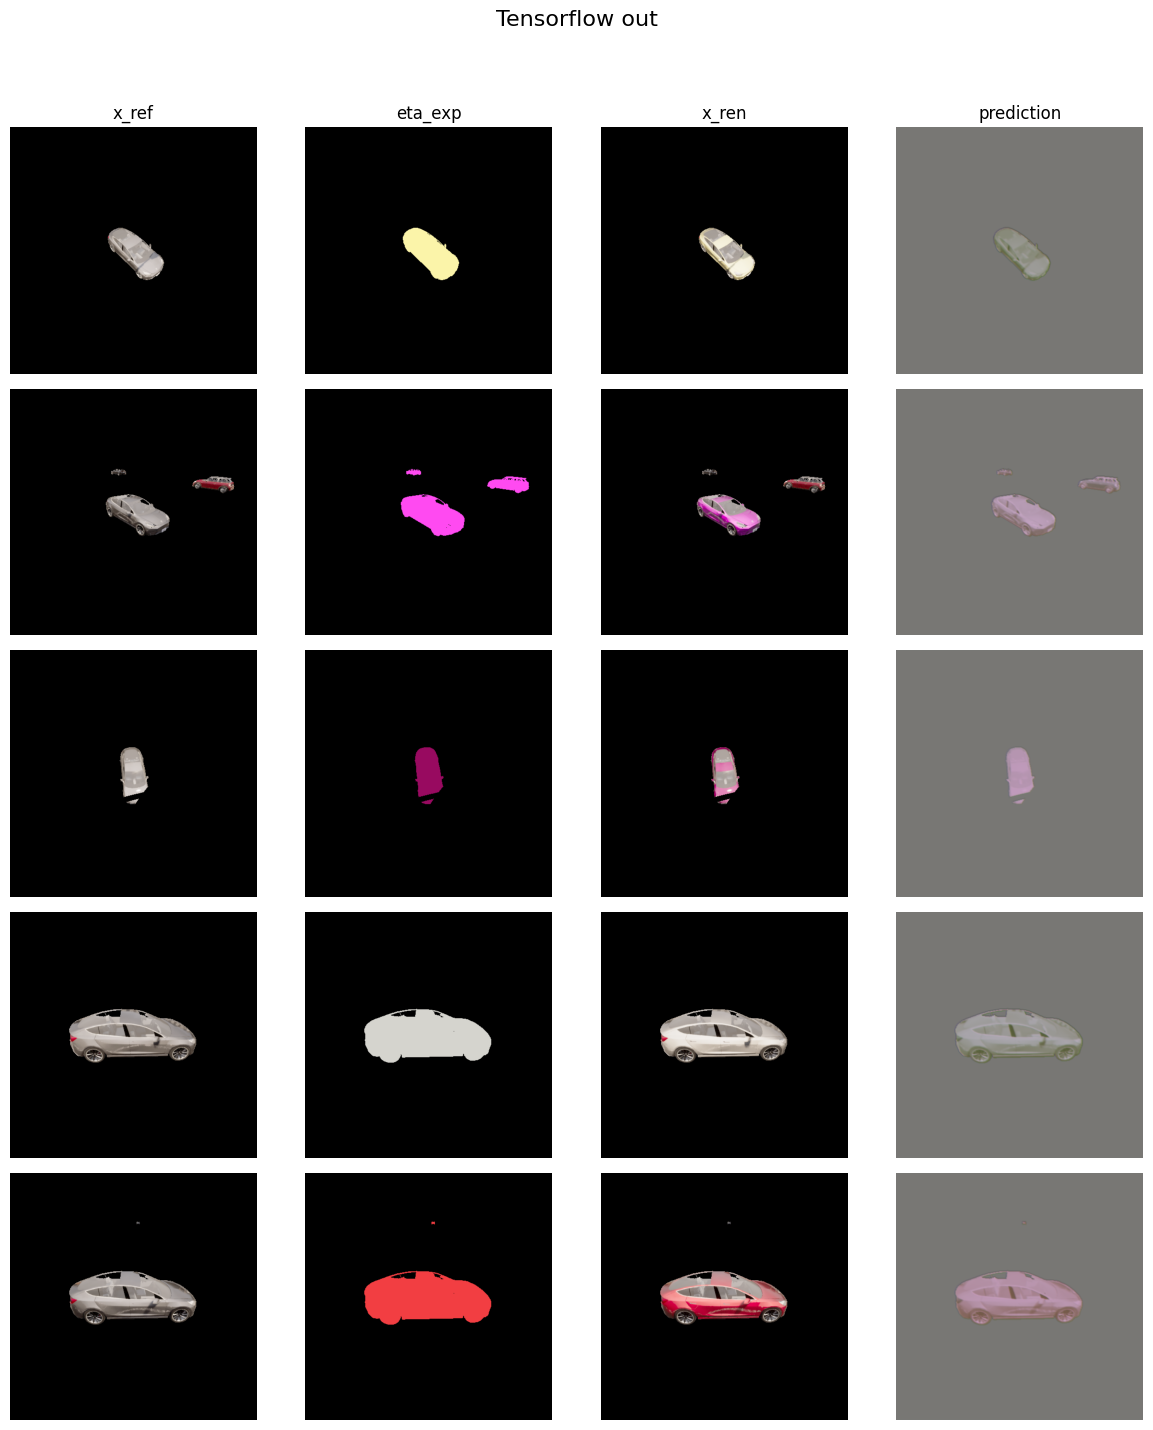

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = model.predict([x_ref[:5], eta_exp[:5]])

# Plot 5 rows × 4 columns (x_ref, eta_exp, x_ren, prediction)
num_samples = 5
titles = ["x_ref", "eta_exp", "x_ren", "prediction"]

plt.figure(figsize=(12, num_samples * 3))

for i in range(num_samples):
    images = [x_ref[i], eta_exp[i], x_ren[i], preds[i]]
    for j in range(4):
        plt.subplot(num_samples, 4, i * 4 + j + 1)
        plt.imshow(np.clip(images[j], 0, 1))
        plt.axis('off')
        if i == 0:
            plt.title(titles[j])

plt.suptitle("Tensorflow out", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## pytorch

### plain nn

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim


device = 'cpu'
print(f"Using {device} device")

Using cpu device


In [53]:
class Dtn(nn.Module):
    def __init__(self):
        super(Dtn, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=3, padding=1),  # 6 channels: x_ref + eta_exp
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),   # Output RGB image
            nn.Sigmoid()  # Keep output in [0, 1]
        )

    def forward(self, x_ref, eta_exp):
        x = torch.cat([x_ref, eta_exp], dim=1)  # Concatenate along channels
        x = self.features(x)
        return x


In [ ]:
import glob
from PIL import Image
import torch
from torchvision import transforms
import numpy as np

# Image size
image_size = (500, 500)

# Define a common transform
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()  # Converts to tensor in [0,1]
])

# Get list of filenames
x_ref_paths = sorted(glob.glob("dataset/reference/*.png"))
eta_exp_paths = sorted(glob.glob("dataset/texture/*.png"))
x_ren_paths = sorted(glob.glob("dataset/rendered/*.png"))

# Load all images into lists (or torch tensors)
x_ref = [transform(Image.open(p).convert("RGB")) for p in x_ref_paths]
eta_exp = [transform(Image.open(p).convert("RGB")) for p in eta_exp_paths]
x_ren = [transform(Image.open(p).convert("RGB")) for p in x_ren_paths]

# Stack into full tensors
x_ref = torch.stack(x_ref)       # Shape: (N, 3, H, W)
eta_exp = torch.stack(eta_exp)   # Shape: (N, 3, H, W)
x_ren = torch.stack(x_ren)       # Shape: (N, 3, H, W)

x_ref, eta_exp, x_ren = x_ref.to(device), eta_exp.to(device), x_ren.to(device)

print("Loaded real datasets...")


Loaded real datasets...


In [56]:
model = Dtn().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20


for epoch in range(num_epochs):
    model.train()
    preds = model(x_ref[95:], eta_exp[95:])
    loss = criterion(preds, x_ren[95:])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.2443
Epoch 2, Loss: 0.2388
Epoch 3, Loss: 0.2330
Epoch 4, Loss: 0.2270
Epoch 5, Loss: 0.2205
Epoch 6, Loss: 0.2137
Epoch 7, Loss: 0.2063
Epoch 8, Loss: 0.1983
Epoch 9, Loss: 0.1897
Epoch 10, Loss: 0.1803
Epoch 11, Loss: 0.1702
Epoch 12, Loss: 0.1592
Epoch 13, Loss: 0.1476
Epoch 14, Loss: 0.1353
Epoch 15, Loss: 0.1227
Epoch 16, Loss: 0.1099
Epoch 17, Loss: 0.0972
Epoch 18, Loss: 0.0847
Epoch 19, Loss: 0.0727
Epoch 20, Loss: 0.0614


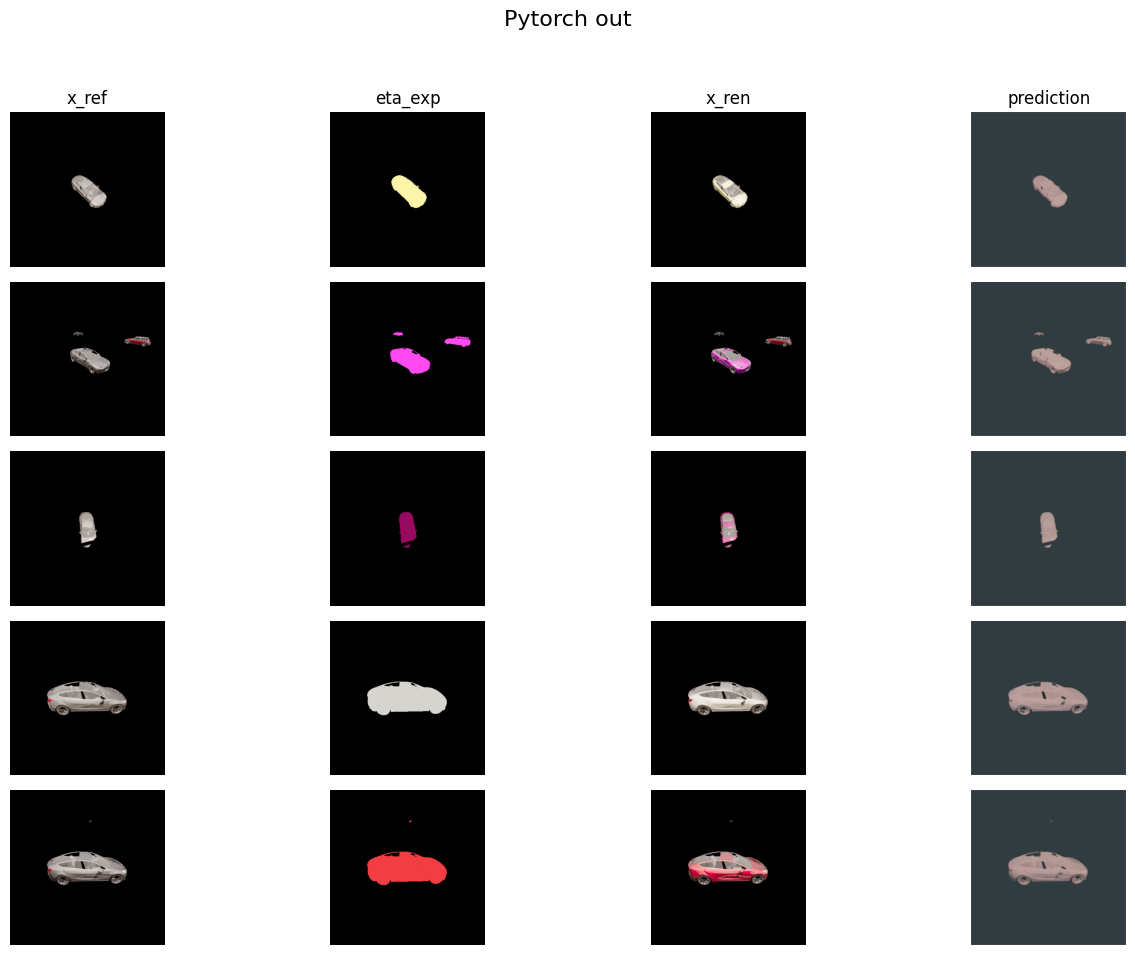

In [58]:
model.eval()
with torch.no_grad():
    pred = model(x_ref[:5], eta_exp[:5]).cpu()

import matplotlib.pyplot as plt
import numpy as np

# Titles per column
titles = ['x_ref', 'eta_exp', 'x_ren', 'prediction']

# Plot: 5 rows × 4 columns
plt.figure(figsize=(14, 10))

for i in range(5):  # for 5 samples
    imgs = [x_ref[i], eta_exp[i], x_ren[i], pred[i]]
    for j in range(4):  # for 4 image types
        ax = plt.subplot(5, 4, i * 4 + j + 1)
        ax.imshow(np.clip(imgs[j].permute(1, 2, 0).cpu().numpy(), 0, 1))
        ax.axis('off')
        if i == 0:
            ax.set_title(titles[j])

plt.suptitle("Pytorch out", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
